# Distribution of backgrounds

### Apr 27, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
# sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/SourceSearch")
# import deDisperse_util as util
import matplotlib.colors as colors

my_path_plots = os.path.abspath("./plots/")
import re


Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


# Get data

In [3]:
srcFolder = "/fs/project/PAS0654/ARA_DATA/A23/10pctCalibBugFix/ValsForCuts/A2/c1/"
file_list=[]#Define an empty list
for filename in os.listdir(srcFolder):#Loop over desired directory
    if filename.endswith("2.root"): #extension, .root in this case
        file_list.append(os.path.join(srcFolder, str(filename))) #add file name to the list
        

In [31]:
VTree = TChain("VTree")
HTree = TChain("HTree")
AllTree = TChain("AllTree")
OutputTree = TChain("OutputTree")
for line in file_list:
    VTree.AddFile(line)
    HTree.AddFile(line)
    AllTree.AddFile(line) 
    OutputTree.AddFile(line)

In [32]:
phi = []
theta = []

numEntries = AllTree.GetEntries()
for event in range(numEntries):
    VTree.GetEntry(event)
    HTree.GetEntry(event)
    AllTree.GetEntry(event)
    OutputTree.GetEntry(event)
    if(AllTree.cal or AllTree.soft or AllTree.CW or AllTree.box or AllTree.bad or AllTree.isFirstFiveEvent
      or AllTree.hasBadSpareChanIssue or AllTree.surf_top_V or AllTree.surf_top_H or VTree.wfrms_val_V_new
     or HTree.wfrms_val_H_new):
        continue
#     print(VTree.wfrms_val_V_new)
    theta.append(VTree.theta_300_V_new)
    phi.append(VTree.phi_300_V_new)

# Look at distributions

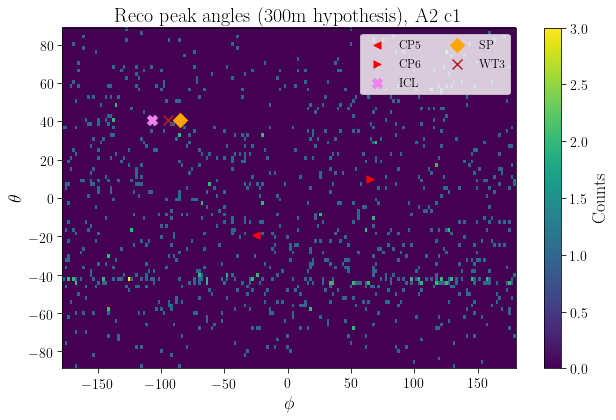

In [33]:
plt.figure(figsize=(9,6))
plt.hist2d(phi,theta, bins=[int(360/2),int(180/2)]);
plt.colorbar(label="Counts")
plt.scatter(-25.02,-19.53, marker="<", s = 50, color="red", label="CP5")
plt.scatter(65.19,9.76, marker=">", s = 50, color="red", label="CP6")
plt.scatter(-106.9,41, marker="X", s = 100, color="violet", label="ICL")
plt.scatter(-84.9,41, marker="D", s = 100, color="orange", label="SP")
plt.scatter(-94.8,41, marker="x", s = 100, color="firebrick", label="WT3")


plt.xlabel("$\phi$")
plt.ylabel("$\\theta$")
plt.title("Reco peak angles (300m hypothesis), A2 c1")
plt.tight_layout()
# plt.grid(alpha=0.6, color = "w", ls = "--")
plt.legend(ncol=2)
# plt.savefig("./A2_c1_bkgDistribution.png", dpi = 200)

## Read from file

In [14]:
bkgFolder = "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_SourceSearch/data_util/"

In [15]:
combined =[]
for config in range(1,6):
#     print(config)
    bkg = pd.read_pickle(bkgFolder+"bkgDistribution_%i.pkl"%config)
    combined.append(bkg)
    
allBkg = pd.concat(combined)

In [16]:
def convertThetatoRange(theta):
    theta = np.radians(theta)
    return np.degrees(np.mod((np.pi/2-theta) ,np.pi))
theta_Conv = convertThetatoRange(allBkg.theta)

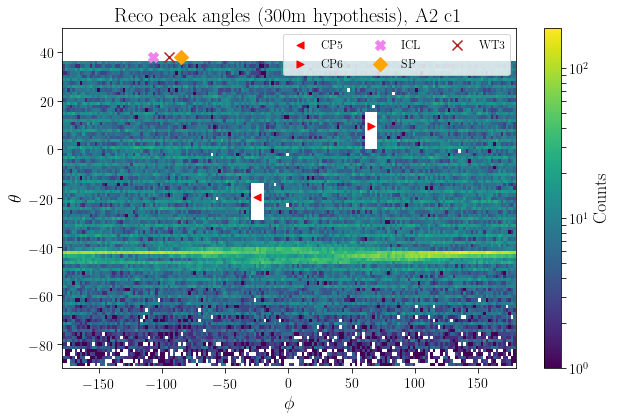

In [17]:
plt.figure(figsize=(9,6))
# plt.hist2d(allBkg.phi,theta_Conv, bins=[int(360/2),int(180/2)]);
plt.hist2d(allBkg.phi,allBkg.theta, bins=[int(360/2),int(180/2)],norm = mpl.colors.LogNorm());

plt.colorbar(label="Counts")
plt.scatter(-25.02,-19.53, marker="<", s = 50, color="red", label="CP5")
plt.scatter(65.19,9.76, marker=">", s = 50, color="red", label="CP6")
plt.scatter(-106.9,38, marker="X", s = 100, color="violet", label="ICL")
plt.scatter(-84.9,38, marker="D", s = 100, color="orange", label="SP")
plt.scatter(-94.8,38, marker="x", s = 100, color="firebrick", label="WT3")


plt.xlabel("$\phi$")
plt.ylabel("$\\theta$")
plt.title("Reco peak angles (300m hypothesis), A2 c1")
plt.tight_layout()
# plt.grid(alpha=0.6, color = "w", ls = "--")
plt.ylim(-90,50)
plt.legend(ncol=3)
# plt.savefig("./A2_c1_bkgDistribution.png", dpi = 200)

## Mollweide proj.

In [18]:
import healpy as hp

In [19]:
def cat2hpx(phi, theta, nside, radec=True):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates

    """

    npix = hp.nside2npix(nside)

#     if radec:
#         eq = SkyCoord(lon, lat, 'icrs', unit='deg')
#         l, b = eq.galactic.l.value, eq.galactic.b.value
#     else:
#         l, b = lon, lat

    # conver to theta, phi
#     theta = np.radians(90. - b)
#     phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

In [39]:
hpx_map = cat2hpx(-np.radians(allBkg.phi),np.radians(theta_Conv), 35)


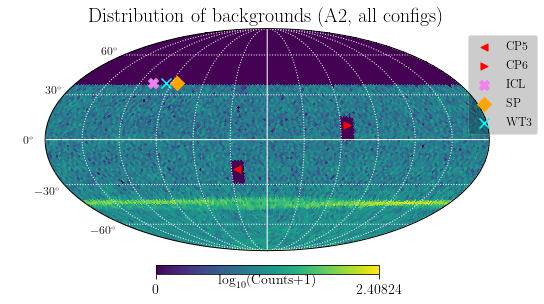

In [40]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
plt.sca(ax)
title = r'sky sca'
themap = hp.mollview(np.log10(hpx_map+1),hold=True, title=title,unit=r'$\log_{10}$(Counts+1)',notext=True )
hp.graticule(color = "white",verbose=True)
ax.tick_params(direction='out', length=6, width=2, colors='r')
plt.title("Distribution of backgrounds (A2, all configs)")
# plt.scatter(np.radians(65.19-90),0.5, marker=">", s = 50, color="red", label="CP6")
hp.projscatter(np.radians(convertThetatoRange(-19.53)), -np.radians(-25.02), color='red',s = 50, marker='<', label='CP5')
hp.projscatter(np.radians(convertThetatoRange(9.76)), -np.radians(65.19), color='red',s = 50, marker='>', label='CP6')
hp.projscatter(np.radians(convertThetatoRange(38)), -np.radians(-106.9), marker="X", s = 100, color="violet", label="ICL")
hp.projscatter(np.radians(convertThetatoRange(38)), -np.radians(-84.9), marker="D", s = 100, color="orange", label="SP")
hp.projscatter(np.radians(convertThetatoRange(38)), -np.radians(-94.8), marker="x", s = 100, color="aqua", label="WT3")
#PLot tick labels
plt.text(-2.2,0., r"$0^\circ$", ha="left", va="center")
plt.text(-2.0,0.45, r"$30^\circ$", ha="left", va="center")
plt.text(-1.5,0.8, r"$60^\circ$", ha="left", va="center")
plt.text(-2.1,-0.45, r"$-30^\circ$", ha="left", va="center")
plt.text(-1.6,-0.8, r"$-60^\circ$", ha="left", va="center")

plt.legend(facecolor = "black",framealpha = 0.2,fancybox=True, bbox_to_anchor=(0.85,0.55),\
    bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.savefig("./bkgDist_mollview_Allconfig.pdf")

In [12]:
allBkg

,theta,phi,unixTime
0,-49,-173,1379237038
1,-18,-170,1379237362
2,-52,32,1379237598
3,-79,82,1379237755
4,-43,163,1379239272
...,...,...,...
77540,-44,31,1466125804
77541,-44,-56,1466125809
77542,20,-167,1466125830
77543,-42,-172,1466125936


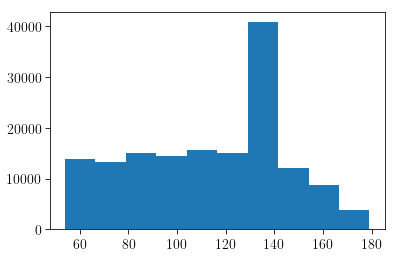

In [13]:
plt.hist(theta_Conv);